In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures 
from sklearn.impute import SimpleImputer 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1 --quiet
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, f1_score
import os
import shap
import joblib
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [33 lines of output]
      Partial import of sklearn during the build process.
      Traceback (most recent call last):
        File "E:\Anaconda\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
          main()
        File "E:\Anaconda\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "E:\Anaconda\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 149, in prepare_metadata_for_build_wheel
          return hook(metadata_directory, config_settings)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\Admin\AppData\Local\Temp\pip-build-env-q18d6lkn\overlay\Lib\site-packages\s

In [2]:
# Load dataset
data_path = 'personality_dataset.csv'
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Dataset not found at {data_path}. Please check the file path.")
data = pd.read_csv(data_path)

In [3]:
# Display basic information
print("Dataset Shape:", data.shape)
print("\nDataset Info:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())

# Define numeric and categorical columns
numeric_columns = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']
categorical_columns = ['Stage_fear', 'Drained_after_socializing']
target_column = 'Personality'

# Verify categorical values
for col in categorical_columns:
    print(f"\nUnique values in {col}:")
    print(data[col].value_counts(dropna=False))

Dataset Shape: (2900, 8)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2837 non-null   float64
 1   Stage_fear                 2827 non-null   object 
 2   Social_event_attendance    2838 non-null   float64
 3   Going_outside              2834 non-null   float64
 4   Drained_after_socializing  2848 non-null   object 
 5   Friends_circle_size        2823 non-null   float64
 6   Post_frequency             2835 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB
None

Missing Values:
Time_spent_Alone             63
Stage_fear                   73
Social_event_attendance      62
Going_outside                66
Drained_after_socializing    52
Friends_circle_size          77
Post_frequency            

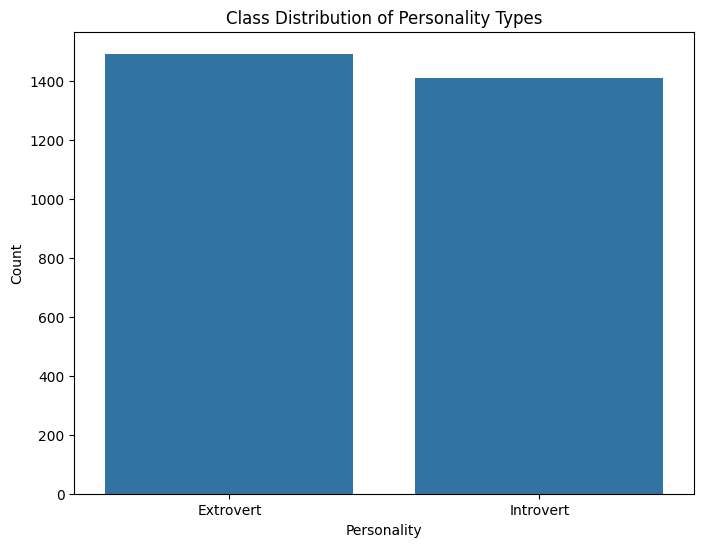

In [4]:
# Class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=target_column, data=data)
plt.title('Class Distribution of Personality Types')
plt.xlabel('Personality')
plt.ylabel('Count')
plt.show()

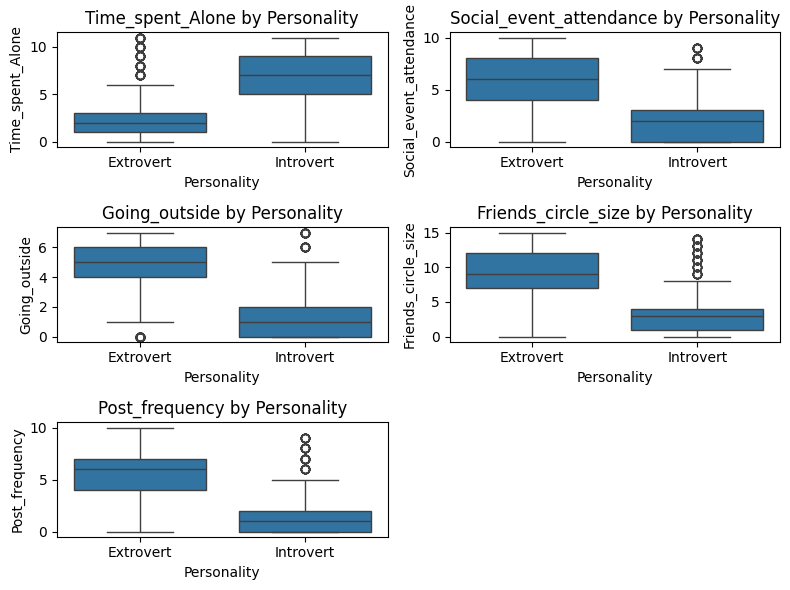

In [5]:
# Numeric feature distributions by class
plt.figure(figsize=(8, 6))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x=target_column, y=col, data=data)
    plt.title(f'{col} by Personality')
plt.tight_layout()
plt.show()

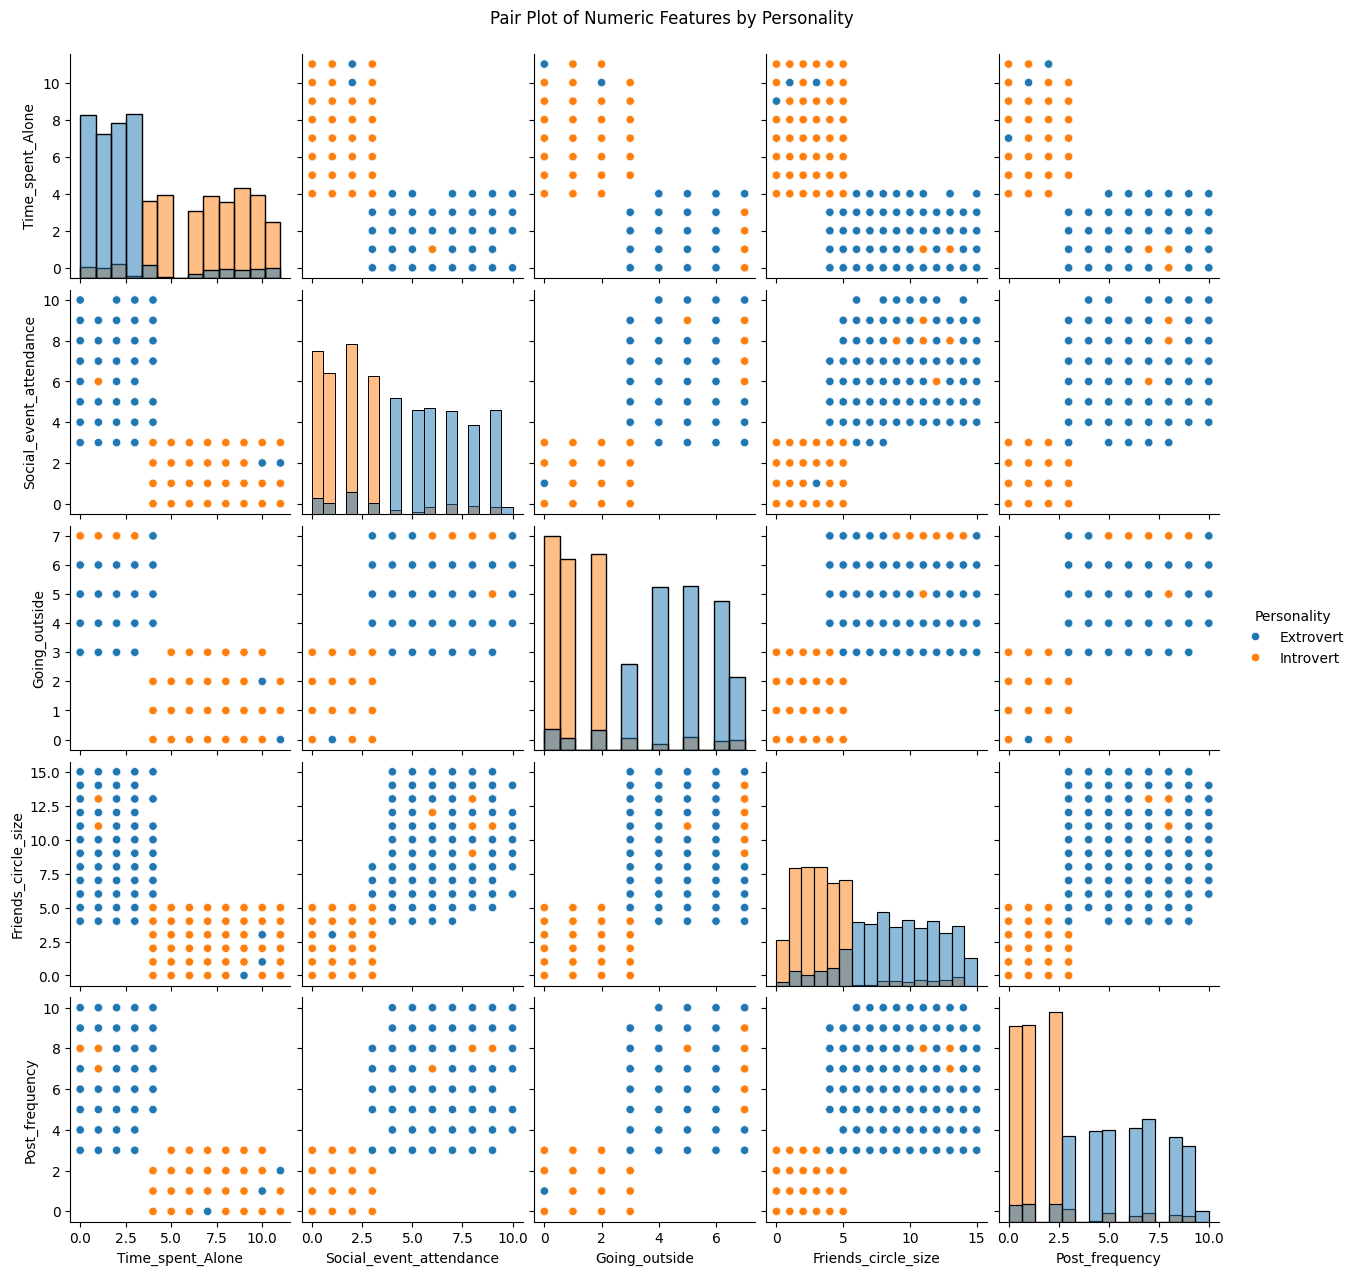

In [6]:
# Pair plot for key features
sns.pairplot(data[numeric_columns + [target_column]], hue=target_column, diag_kind='hist')
plt.suptitle('Pair Plot of Numeric Features by Personality', y=1.02)
plt.show()

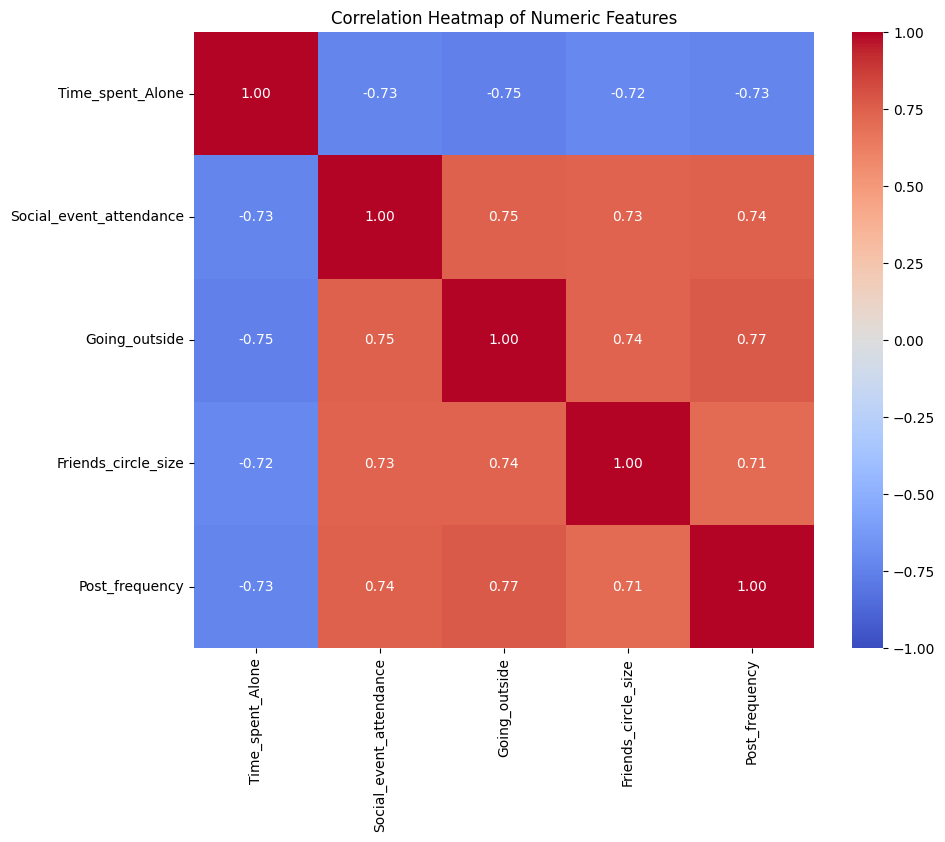

In [7]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data[numeric_columns].corr(), annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

In [8]:
# Encode target variable
le = LabelEncoder()
data[target_column] = le.fit_transform(data[target_column])
print(f"Encoded classes: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Handle missing values
# Numeric features: impute with median
numeric_imputer = SimpleImputer(strategy='median')
data[numeric_columns] = numeric_imputer.fit_transform(data[numeric_columns])

# Categorical features: impute with mode
categorical_imputer = SimpleImputer(strategy='most_frequent')
data[categorical_columns] = categorical_imputer.fit_transform(data[categorical_columns])

# Encode categorical features
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Update feature list
encoded_columns = [col for col in data.columns if col != target_column]

# Cap outliers instead of removing
for col in numeric_columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

Encoded classes: {'Extrovert': np.int64(0), 'Introvert': np.int64(1)}


In [9]:
# Train-test split
X = data.drop(columns=[target_column])
y = data[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [10]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Interaction features
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)
X_train['Alone_to_Social_Ratio'] = X_train['Time_spent_Alone'] / (X_train['Social_event_attendance'] + 1)
X_test['Alone_to_Social_Ratio'] = X_test['Time_spent_Alone'] / (X_test['Social_event_attendance'] + 1)
X_train['Social_Comfort_Index'] = (X_train['Friends_circle_size'] + X_train['Post_frequency'] - X_train['Stage_fear_Yes']) / 3
X_test['Social_Comfort_Index'] = (X_test['Friends_circle_size'] + X_test['Post_frequency'] - X_test['Stage_fear_Yes']) / 3
X_train['Social_Overload'] = X_train['Drained_after_socializing_Yes'] * X_train['Social_event_attendance']
X_test['Social_Overload'] = X_test['Drained_after_socializing_Yes'] * X_test['Social_event_attendance']

# Binned features
X_train['Time_spent_Alone_Binned'] = pd.qcut(X_train['Time_spent_Alone'], q=3, labels=['Low', 'Medium', 'High'])
X_test['Time_spent_Alone_Binned'] = pd.qcut(X_test['Time_spent_Alone'], q=3, labels=['Low', 'Medium', 'High'])
X_train = pd.get_dummies(X_train, columns=['Time_spent_Alone_Binned'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Time_spent_Alone_Binned'], drop_first=True)

# Polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly_features_train = poly.fit_transform(X_train[['Time_spent_Alone', 'Social_event_attendance', 'Friends_circle_size']])
poly_features_test = poly.transform(X_test[['Time_spent_Alone', 'Social_event_attendance', 'Friends_circle_size']])
poly_feature_names = poly.get_feature_names_out(['Time_spent_Alone', 'Social_event_attendance', 'Friends_circle_size'])
X_train[poly_feature_names] = poly_features_train
X_test[poly_feature_names] = poly_features_test

# Update scaled features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Define models with expanded hyperparameter grids
models = {
    'logistic': {
        'model': LogisticRegression(max_iter=1000),
        'use_scaled': True,
        'params': {'C': np.logspace(-4, 4, 20), 'solver': ['lbfgs', 'liblinear']}
    },
    'svm': {
        'model': SVC(probability=True),
        'use_scaled': True,
        'params': {'C': np.logspace(-3, 3, 20), 'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto', 0.1, 1]}
    },
    'rf': {
        'model': RandomForestClassifier(random_state=42),
        'use_scaled': False,
        'params': {'n_estimators': [100, 150], 'max_depth': [None, 10], 'min_samples_split': [2, 5]}
    },
    'gb': {
        'model': GradientBoostingClassifier(random_state=42),
        'use_scaled': False,
        'params': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
    },
    'knn': {
        'model': KNeighborsClassifier(),
        'use_scaled': True,
        'params': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
    },
    'dt': {
        'model': DecisionTreeClassifier(random_state=42),
        'use_scaled': False,
        'params': {'max_depth': [None, 5, 10, 15], 'min_samples_split': [2, 5, 10]}
    },
    'xgb': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'use_scaled': False,
        'params': {'n_estimators': [100, 150], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5], 'subsample': [0.8]}
    }
}

In [13]:
# Hyperparameter tuning
results = []
for model_name, mp in models.items():
    clf = RandomizedSearchCV(mp['model'], mp['params'], n_iter=20, cv=3, scoring='f1_weighted', n_jobs=-1, random_state=42)
    X_train_current = X_train_scaled if mp['use_scaled'] else X_train
    clf.fit(X_train_current, y_train)
    results.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

In [14]:
# Display model performance
df_results = pd.DataFrame(results)
print("\nModel Performance (Cross-Validation F1-Weighted Scores):")
print(df_results)


Model Performance (Cross-Validation F1-Weighted Scores):
      model  best_score                                        best_params
0  logistic    0.938387    {'solver': 'lbfgs', 'C': 0.0006951927961775605}
1       svm    0.938387  {'kernel': 'rbf', 'gamma': 0.1, 'C': 12.742749...
2        rf    0.938387  {'n_estimators': 100, 'min_samples_split': 5, ...
3        gb    0.936709  {'n_estimators': 100, 'max_depth': 3, 'learnin...
4       knn    0.937129           {'weights': 'uniform', 'n_neighbors': 7}
5        dt    0.932516           {'min_samples_split': 2, 'max_depth': 5}
6       xgb    0.937129  {'subsample': 0.8, 'n_estimators': 150, 'max_d...


In [15]:
# Stacking ensemble
estimators = [
    ('rf', RandomForestClassifier(**df_results.loc[df_results['model'] == 'rf']['best_params'].iloc[0], random_state=42)),
    ('gb', GradientBoostingClassifier(**df_results.loc[df_results['model'] == 'gb']['best_params'].iloc[0], random_state=42)),
    ('xgb', XGBClassifier(**df_results.loc[df_results['model'] == 'xgb']['best_params'].iloc[0], random_state=42, eval_metric='logloss')),
    ('svm', SVC(**df_results.loc[df_results['model'] == 'svm']['best_params'].iloc[0], probability=True))
]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=1000), n_jobs=-1)
stacking_model.fit(X_train_scaled, y_train)

# Cross-validation for stacking model
stacking_scores = cross_val_score(stacking_model, X_train_scaled, y_train, cv=3, scoring='f1_weighted', n_jobs=-1)
print(f"\nStacking Model Cross-Validation F1-Weighted Score: {stacking_scores.mean():.3f} ± {stacking_scores.std():.3f}")


Stacking Model Cross-Validation F1-Weighted Score: 0.938 ± 0.002


In [16]:
# Evaluate on test set
y_pred = stacking_model.predict(X_test_scaled)
print("\nStacking Model Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Stacking Model Classification Report:
              precision    recall  f1-score   support

   Extrovert       0.94      0.90      0.92       298
   Introvert       0.90      0.94      0.92       282

    accuracy                           0.92       580
   macro avg       0.92      0.92      0.92       580
weighted avg       0.92      0.92      0.92       580



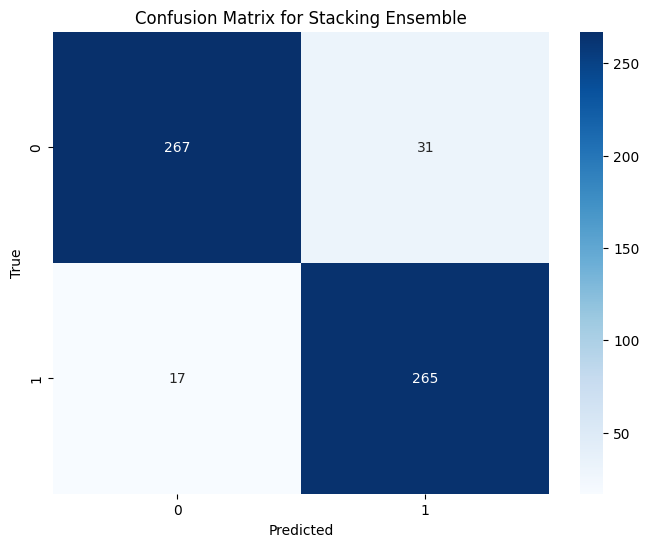

In [17]:
# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Stacking Ensemble')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

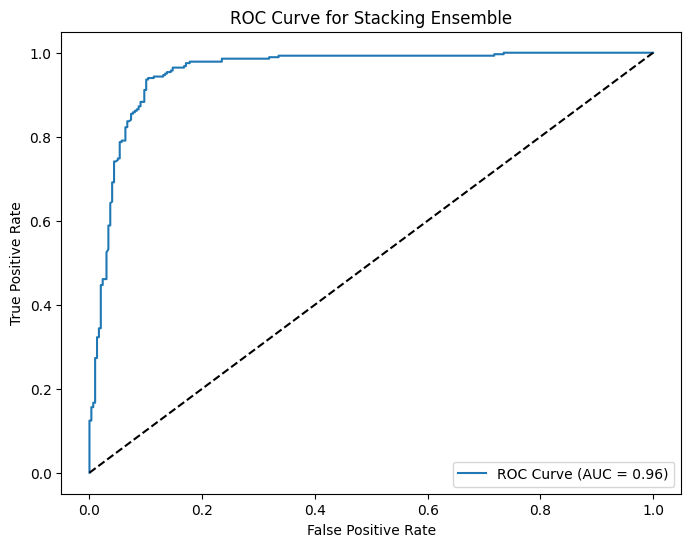

In [18]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, stacking_model.predict_proba(X_test_scaled)[:, 1])
roc_auc = roc_auc_score(y_test, stacking_model.predict_proba(X_test_scaled)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Stacking Ensemble')
plt.legend()
plt.show()